In [3]:
cuda_device = "0"

In [4]:
import os
import time
import copy
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=cuda_device
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from haven import haven_utils as hu
import open3d as o3d
from open3d.web_visualizer import draw
o3d.visualization.webrtc_server.enable_webrtc()

import numpy as np
import torch
import torch.nn
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from src import models
from src.scenes import NeuralScene
from src.pointcloud_lightfield.ptlf_vis import get_pcd_vis
from src import utils as ut

from pytorch3d.transforms.rotation_conversions import euler_angles_to_matrix, matrix_to_euler_angles, matrix_to_quaternion, quaternion_to_matrix
from pytorch3d.transforms.so3 import so3_log_map, so3_exponential_map

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


Define Path to model checkpoint, dataset and load checkpoint

In [5]:
# No augmentation
# savedir = '/mnt/storage01-mun/dataset/users/jost/experiments_nsg/a906a4bc375cb4c4750ded034df95aed'
# Augmentation
# savedir = '/mnt/storage01-mun/dataset/users/jost/experiments_nsg/44806b376d13b133913125852fe93254'
# Augmentation Scene 1, 15
savedir = '/mnt/storage01-mun/dataset/users/jost/experiments_nsg/f827b228e970e44590da5177e4a4b7d7'
# More Cams 0, 8
# savedir = '/mnt/storage01-mun/dataset/users/jost/experiments_nsg/f30490e147605837cca011a093be562c'

# savedir = '/mnt/storage01-mun/dataset/users/jost/experiments_nsg/c5f41bc7d4f6848b10d466b5b5e122ec'
# savedir = '/mnt/storage01-mun/dataset/users/jost/experiments_nsg/c05fe615b1c40a40eef2b252c7bd784f'
savedir = '/mnt/storage01-mun/dataset/users/jost/experiments_nsg/132fe337a34cf51ff2f50d8e85440bd2'
# savedir = '/mnt/storage01-mun/dataset/users/jost/experiments_nsg/4def4aa7084f4f82fb56a3ff09fe7850'
# savedir = '/mnt/storage01-mun/dataset/users/jost/experiments_nsg/a2dd0a08d5558bc0ce779126549c4cad'

datadir = '/mnt/storage01-mun/dataset/users/jost/waymo_open/validation'

exp_dict = hu.load_json(os.path.join(savedir, 'exp_dict.json'))
model_state_dict = hu.torch_load(os.path.join(savedir, 'model.pth'))

If running localy, change number of rays and the macimum chunk size of the point sampler

In [6]:
exp_dict['n_rays'] = 8192*2
# exp_dict['chunk'] = 512
lf_config = exp_dict["lightfield"]
# exp_dict["lightfield"]["n_sample_pts"] = 7000
lf_config
# exp_dict["scale"] = 0.0625

{'D_lf': 8,
 'W_lf': 256,
 'all_cams': False,
 'augment_frame_order': True,
 'camera_centered': False,
 'k_closest': 8,
 'layer_modulation': False,
 'merge_pcd': True,
 'n_features': 128,
 'n_sample_pts': 20000,
 'new_enc': False,
 'optimize_cam': False,
 'pointfeat_encoder': 'multiview_attention',
 'skips_lf': [4],
 'sky_dome': True,
 'torch_sampler': True}

Create Scene and Model

In [7]:
# 
seed = 42 + exp_dict.get("runs", 0)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

args = None

scene = NeuralScene(
    scene_list=exp_dict["scenes"],
    datadir=datadir,
    args=args,
    exp_dict=exp_dict,
)

model = models.Model(scene, exp_dict, precache=exp_dict.get("precache"))

# Load checkpoint
model.renderer.load_state_dict(
        model_state_dict["renderer"], strict=False
    )

# Load checkpoint
# chk_dict = hw.get_checkpoint(savedir, return_model_state_dict=True)

# if len(chk_dict["model_state_dict"]):
#     model.set_state_dict(chk_dict["model_state_dict"])

Loaded Waymo

loaded scene segment-10247954040621004675_2180_000_2200_000_with_camera_labels with 405 frames.
Extracting Data for Baseline Experiments
Loaded Nodes in 0.006 seconds


Loaded Frames in 12.317 seconds


<All keys matched successfully>

In [8]:
batch_size = 1
epoch_size = 1
rand_sampler = torch.utils.data.RandomSampler(
    scene, num_samples=epoch_size * batch_size, replacement=True
)

scene_loader = torch.utils.data.DataLoader(
    scene,
    sampler=rand_sampler,
    collate_fn=ut.collate_fn_dict_of_lists,
    batch_size=batch_size,
    num_workers=0,
    # pin_memory=True,
    drop_last=True,
)

In [98]:
reference_id = 59
# reference_id = 25
# reference_id = 129

ind_list = list(np.arange(len(scene)))
bi = ind_list[reference_id]

Choose frame camera pair

In [172]:
exp_name = 'middle_curve_01'

euler_mid = None
translation_mid = None

# Rotation ('ZYX'/"ROLL", "YAW", "PITCH")
euler_start = np.array([np.deg2rad(0.),np.deg2rad(0.),np.deg2rad(0.)])
euler_mid = np.array([np.deg2rad(0.),np.deg2rad(-9.),np.deg2rad(0.)])
euler_end = np.array([np.deg2rad(0.),np.deg2rad(-11.),np.deg2rad(0.)])

# euler_start = np.array([np.deg2rad(0.),np.deg2rad(-8.),np.deg2rad(0.)])
# euler_end = np.array([np.deg2rad(0.),np.deg2rad(8.),np.deg2rad(0.)])

# Translation in camera space; when level: 1.-"LEFT", 2.-"UP", 3.-"FORWARD"
translation_start = np.array([0.,0.0,0.0])
translation_mid = np.array([1.25,0.0,4.0])
translation_end = np.array([0.75,0.0,7.5])

# translation_start = np.array([3,0.0,0.0])
# translation_end = np.array([-3,0.0,0.0])

n_steps = 12

render_reference = False

pose_only = False

img_name = os.path.join(savedir, 'images/interpolation/', (exp_name + '_'))

ind_list = list(np.arange(len(scene)))
bi = ind_list[reference_id]
print(img_name)

/mnt/storage01-mun/dataset/users/jost/experiments_nsg/132fe337a34cf51ff2f50d8e85440bd2/images/interpolation/middle_curve_01_


### a) Load batch for a random subset from the images pixels as in training

In [13]:
with torch.no_grad():
    time0 = time.time()
    b = ut.collate_fn_dict_of_lists([scene.__getitem__(bi, intersections_only=True, random_rays=True)])
    print(time.time()-time0)

2.639235258102417


### b) Render batch from all image pixels

3.0608041286468506
1.4156544208526611


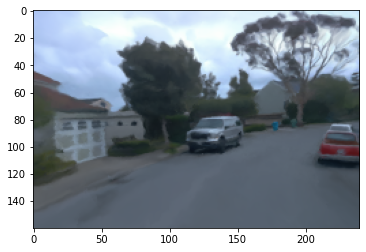

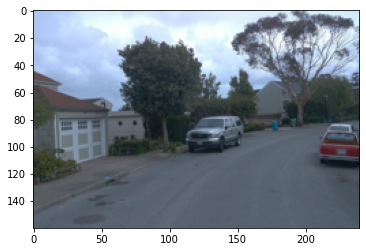

In [50]:
with torch.no_grad():
    time0 = time.time()
    b = ut.collate_fn_dict_of_lists([scene.__getitem__(bi, intersections_only=False, random_rays=False,)])
    print(time.time()-time0)
    time1 = time.time()
    rgb_out = model.renderer.forward_on_batch(b)
    print(time.time()-time1)

rendered_img = rgb_out['color_out'].reshape(b['images'][0].shape)
plt.figure()
plt.imshow(rendered_img)
plt.figure()
plt.imshow(b["images"][0].detach().cpu())

### c) Val complete scene

In [54]:
val_dict = model.val_on_scene(scene, savedir_images=os.path.join(savedir, "images"), all_frames=True)

psnr: 26.02: 100%|██████████| 81/81 [06:43<00:00,  4.99s/it]


### d) Create New Frames

In [12]:
def get_render_cam_trafo(translation, euler_angles, scene, reference_id):
    print("Manipulating Reference Frame.")
    
    ind_list = list(np.arange(len(scene)))
    
    # Copy reference frame
    ref_frame_idx = scene.frames_cameras[reference_id][0]
    
    new_frame = scene.frames[ref_frame_idx]
    ref_new_frame_copy = copy.deepcopy(new_frame)
    cam_idx = 1
    # print([(node_idx, cam_node.name) for (node_idx, cam_node) in scene.nodes['camera'].items()])
    assert scene.nodes['camera'][cam_idx].name == 'FRONT'
    camera_ed = new_frame.get_edge_by_child_idx([cam_idx])[0][0]
    cam_ed_idx = new_frame.get_edge_idx_by_child_idx([cam_idx])[0][0]
    # print(camera_ed.get_transformation_c2p().get_matrix().detach().cpu().numpy()[0].T)
    rot_skew_angle = copy.deepcopy(camera_ed.rotation)
    cam2wo_rot = so3_exponential_map(rot_skew_angle)
    cam2wo_translat = copy.deepcopy(camera_ed.translation)
    # print(cam2wo_rot)


    # Create new camera edge
    DTYPE = camera_ed.translation.dtype
    DEVICE = camera_ed.translation.device

    # Get changed rotation
    euler_angels_torch = torch.tensor(euler_angles, dtype=DTYPE, device=DEVICE)
    rot_change = euler_angles_to_matrix(euler_angels_torch, 'ZYX')
    new_rot = torch.matmul(cam2wo_rot, rot_change)
    assert torch.norm(torch.matmul(new_rot[0], new_rot[0].T) - torch.eye(3)) < 1e-5

    # Get changed camera
    translation_change_camera = torch.tensor(translation_change, dtype=DTYPE, device=DEVICE)
    translation_change_world = torch.matmul(new_rot[0], translation_change_camera)

    translation_world = cam2wo_translat + translation_change_world
    camera_ed.translation = translation_world
    print("Reference Translation: {}; New Translation {}".format(
        cam2wo_translat.detach().cpu().numpy(),
        scene.frames[reference_id].edges[cam_ed_idx].translation.detach().cpu().numpy()))
    camera_ed.rotation = so3_log_map(new_rot)
    print("Reference Rotation: {}; New Rotation {}".format(
        rot_skew_angle.detach().cpu().numpy(),
        scene.frames[reference_id].edges[cam_ed_idx].rotation.detach().cpu().numpy()))
    

    # Output new frame
    translation_world = translation_world.detach().cpu().numpy()
    rotation_world = new_rot.detach().cpu().numpy()
    
    # Reverse Scene Graph Manipulation
    scene.frames[ref_frame_idx] = copy.deepcopy(ref_new_frame_copy)
    
    return translation_world, rotation_world
    

In [13]:
def get_rotation_steps(euler_start, euler_end, n_steps):
    # Rotation Interpolation with slerp
    mat_start = euler_angles_to_matrix(torch.tensor(euler_start), "ZYX")
    quat_start = matrix_to_quaternion(mat_start)

    mat_end = euler_angles_to_matrix(torch.tensor(euler_end), "ZYX")
    quat_end = matrix_to_quaternion(mat_end)
    
    new_euler_ls = []
    steps = torch.linspace(0, 1, n_steps)
    
    cosHalfTheta = torch.sum(quat_start * quat_end)
    halfTheta = torch.acos(cosHalfTheta)
    sinHalfTheta = torch.sqrt(1.0 - cosHalfTheta * cosHalfTheta)
    
    if halfTheta != 0:
        ratioA = torch.sin((1 - steps) * halfTheta) / sinHalfTheta
        ratioB = torch.sin(steps * halfTheta) / sinHalfTheta
        mid_quat = quat_start * ratioA[:, None] + quat_end * ratioB[:, None]
        for i in range(n_steps):
            new_quat = mid_quat[i, None]
            new_euler = matrix_to_euler_angles(quaternion_to_matrix(new_quat), "ZYX")
            new_euler_ls.append(new_euler.numpy())
    else:
        for i in range(n_steps):
            new_euler_ls.append(euler_start)
        
    
        
    return new_euler_ls

In [164]:
def render_frame_from_cam_trafo(translation, euler_angles, scene, reference_id):
    print("Manipulating Reference Frame.")
    
    ind_list = list(np.arange(len(scene)))
    
    # Copy reference frame
    ref_frame_idx = scene.frames_cameras[reference_id][0]
    
    new_frame = scene.frames[ref_frame_idx]
    ref_new_frame_copy = copy.deepcopy(new_frame)
    cam_idx = 1
    # print([(node_idx, cam_node.name) for (node_idx, cam_node) in scene.nodes['camera'].items()])
    assert scene.nodes['camera'][cam_idx].name == 'FRONT'
    camera_ed = new_frame.get_edge_by_child_idx([cam_idx])[0][0]
    cam_ed_idx = new_frame.get_edge_idx_by_child_idx([cam_idx])[0][0]
    # print(camera_ed.get_transformation_c2p().get_matrix().detach().cpu().numpy()[0].T)
    rot_skew_angle = copy.deepcopy(camera_ed.rotation)
    cam2wo_rot = so3_exponential_map(rot_skew_angle)
    cam2wo_translat = copy.deepcopy(camera_ed.translation)
    # print(cam2wo_rot)


    # Create new camera edge
    DTYPE = camera_ed.translation.dtype
    DEVICE = camera_ed.translation.device

    # Get changed rotation
    euler_angels_torch = torch.tensor(euler_angles, dtype=DTYPE, device=DEVICE)
    rot_change = euler_angles_to_matrix(euler_angels_torch, 'ZYX')
    new_rot = torch.matmul(cam2wo_rot, rot_change)
    assert torch.norm(torch.matmul(new_rot[0], new_rot[0].T) - torch.eye(3)) < 1e-5

    # Get changed camera
    translation_change_camera = torch.tensor(translation_change, dtype=DTYPE, device=DEVICE)
    translation_change_world = torch.matmul(new_rot[0], translation_change_camera)

    translation_world = cam2wo_translat + translation_change_world
    camera_ed.translation = translation_world
    print("Reference Translation: {}; New Translation {}".format(
        cam2wo_translat.detach().cpu().numpy(),
        scene.frames[reference_id].edges[cam_ed_idx].translation.detach().cpu().numpy()))
    camera_ed.rotation = so3_log_map(new_rot)
    print("Reference Rotation: {}; New Rotation {}".format(
        rot_skew_angle.detach().cpu().numpy(),
        scene.frames[reference_id].edges[cam_ed_idx].rotation.detach().cpu().numpy()))
    
    # Get best point cloud
    li_node_id = [(key, li.name) for key, li in scene.nodes['lidar'].items() if li.name == 'TOP'][0][0]
    distance = np.linalg.norm(cam2wo_translat.detach().cpu().numpy() - scene.frames[reference_id].edges[cam_ed_idx].translation.detach().cpu().numpy())
    closest_frame_idx = reference_id
    for i in range(len(scene)-reference_id-1):
        check_frame_id = i+reference_id+1
        check_cam_ed = scene.frames[check_frame_id].get_edge_by_child_idx([1])[0][0]
        distance_3D = check_cam_ed.translation - scene.frames[reference_id].edges[cam_ed_idx].translation
        new_dist = torch.norm(distance_3D)
        # print(new_dist)
        if new_dist < distance:
            distance = new_dist
            closest_frame_idx = check_frame_id
            
    
    print("Old PT Cloud Path: {}; New PT Cloud Path: {}".format(scene.frames[reference_id].point_cloud_pth[li_node_id], 
                                                                scene.frames[closest_frame_idx].point_cloud_pth[li_node_id]))
    
    scene.frames[reference_id].point_cloud_pth[li_node_id] = scene.frames[closest_frame_idx].point_cloud_pth[li_node_id]
    
    # Preprocess new frame
    print("Extracting rays and klosest points.")
    bi = ind_list[reference_id]
    batch = ut.collate_fn_dict_of_lists([scene.__getitem__(bi, intersections_only=False, random_rays=False,)])
    print("Done.")
    print("Rendering New Frame.")
    rgb_out = model.renderer.forward_on_batch(batch)
    ref_shape = batch['images'][0].shape
    print("Done.")
    translation_world = translation_world.detach().cpu().numpy()
    rotation_world = new_rot.detach().cpu().numpy()
    
    # Reverse Scene Graph Manipulation
    scene.frames[ref_frame_idx] = copy.deepcopy(ref_new_frame_copy)
    
    return rgb_out, ref_shape, translation_world, rotation_world
    

2
Translational Change from Reference (m): [0. 0. 0.].
Rotational Change from Reference (deg): [[ 0. -0.  0.]].
Manipulating Reference Frame.
Reference Translation: [[-5901.2373  11199.111     171.51765]]; New Translation [[-5901.2373  11199.111     171.51765]]
Reference Rotation: [[1.5270799  0.44696978 0.50660974]]; New Rotation [[1.5270799  0.44696978 0.50660974]]
Old PT Cloud Path: /home/julian.ost/workspace/renderer/NeuralSceneGraphs/data/waymo_open/validation/validation_validation_0000/segment-10247954040621004675_2180_000_2200_000_with_camera_labels/point_cloud/059_TOP.ply; New PT Cloud Path: /home/julian.ost/workspace/renderer/NeuralSceneGraphs/data/waymo_open/validation/validation_validation_0000/segment-10247954040621004675_2180_000_2200_000_with_camera_labels/point_cloud/059_TOP.ply
Extracting rays and klosest points.
Done.
Rendering New Frame.
Done.
Translational Change from Reference (m): [0.11363636 0.         0.36363636].
Rotational Change from Reference (deg): [[ 0.    

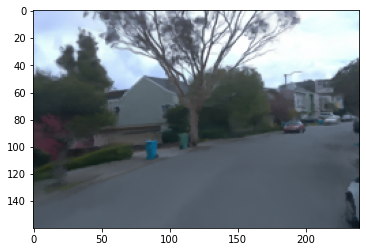

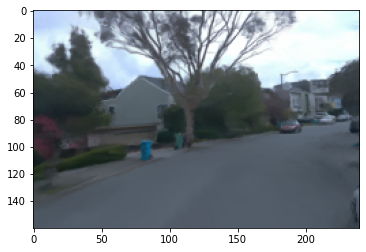

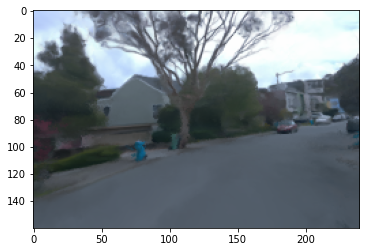

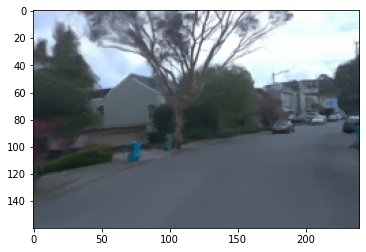

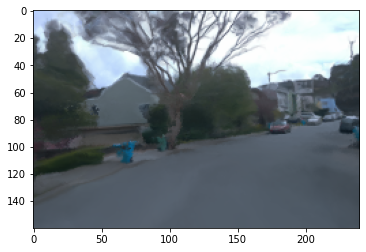

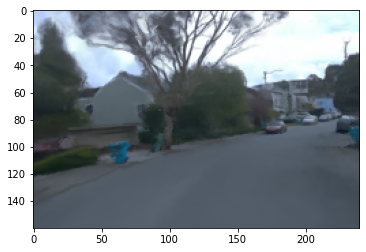

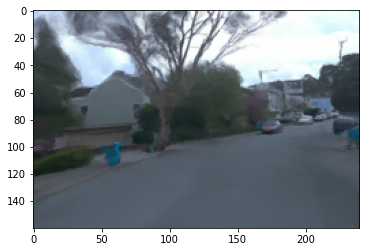

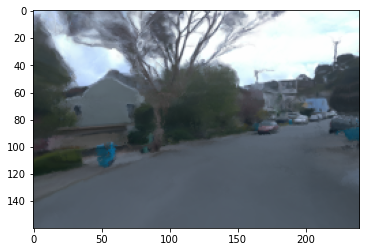

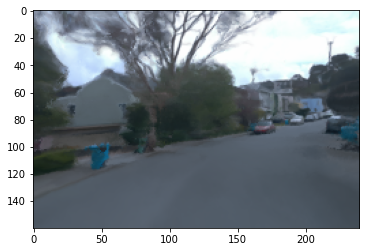

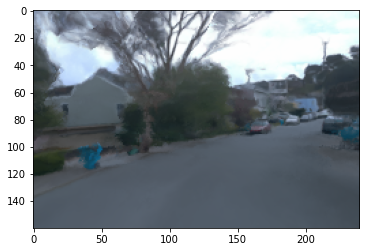

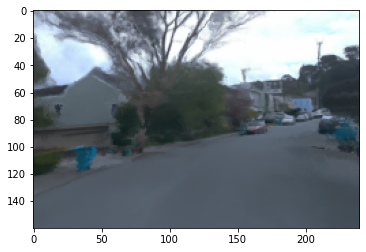

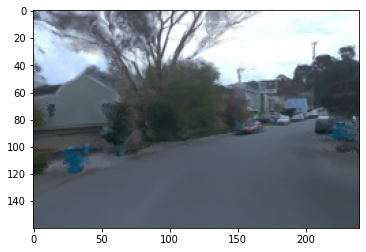

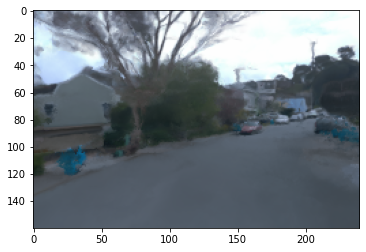

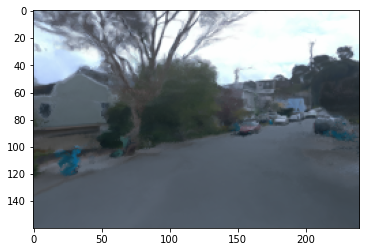

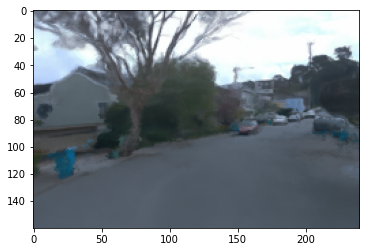

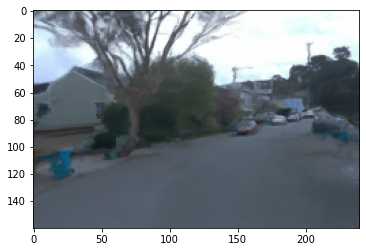

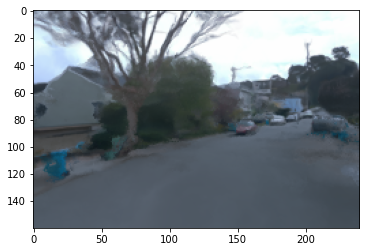

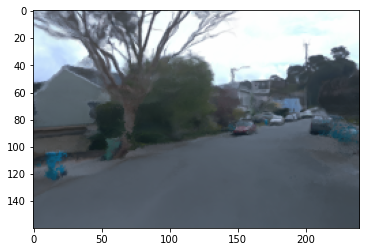

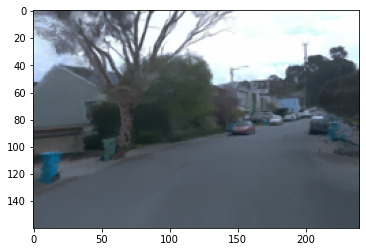

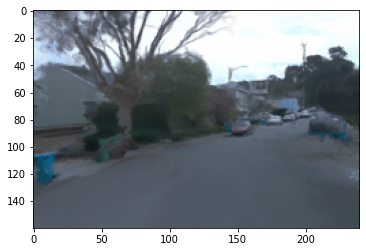

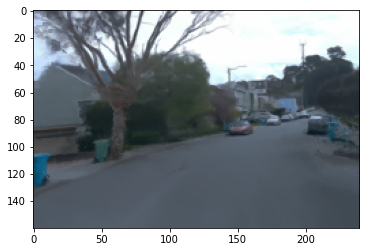

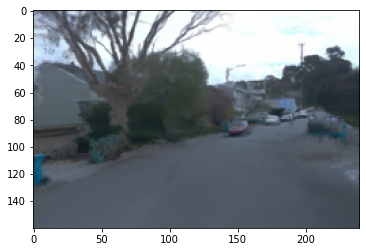

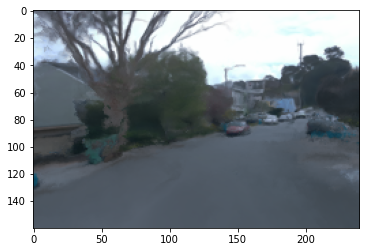

In [173]:
midpoint = False
if translation_mid is None:
    d_translation = translation_end - translation_start
    traj_start = translation_start
else:
    d_translation = translation_mid - translation_start
    traj_start = translation_start
    midpoint = True
# print(d_translation)
if euler_mid is None:
    new_euler = get_rotation_steps(euler_start, euler_end, n_steps)
else:
    new_euler = get_rotation_steps(euler_start, euler_mid, n_steps)
    midpoint = True
    

if render_reference:
    print("Reference Remdering")
    with torch.no_grad():
        ind_list = list(np.arange(len(scene)))
        bi = ind_list[reference_id]
        b = ut.collate_fn_dict_of_lists([scene.__getitem__(bi, intersections_only=False, random_rays=False,)])
        print(b)
        rgb_out = model.renderer.forward_on_batch(b)
        plt.figure()
        rendered_img = rgb_out['color_out'].reshape(b['images'][0].shape)
        plt.imshow(rendered_img)

imgs = []
cam_position = []
cam_orientation = []
n_points = 1 + 1 * midpoint
print(n_points)
for p in range(n_points):
    
    for step, euler_angles in enumerate(new_euler):
        if n_steps > 1:
            step_sz = d_translation * (step / (n_steps-1))
        else:
            step_sz = np.zeros_like(translation_start)

        translation_change = traj_start + step_sz
        print("Translational Change from Reference (m): {}.".format(translation_change))


        print("Rotational Change from Reference (deg): {}.".format(np.rad2deg(euler_angles)))


        if not pose_only:
            with torch.no_grad():
                  rgb_out, ref_shape, new_translation, new_rotation = \
                    render_frame_from_cam_trafo(translation_change, euler_angles, scene, reference_id)

            plt.figure()
            rendered_img = rgb_out['color_out'].reshape(ref_shape)
            imgs.append(rendered_img)
            plt.imshow(rendered_img)
        else:
            new_translation, new_rotation = get_render_cam_trafo(translation_change, euler_angles, scene, reference_id)

        cam_position.append(new_translation)
        cam_orientation.append(new_rotation)
    
    if midpoint:
        new_euler = get_rotation_steps(euler_mid, euler_end, n_steps)[1:]
        d_translation = translation_end - translation_mid
        traj_start = translation_mid + (d_translation * (1 / (n_steps-1)))

    
cam_position = np.concatenate(cam_position)
cam_orientation = np.concatenate(cam_orientation)

In [176]:
from PIL import Image
if not os.path.exists(os.path.join(savedir, 'images/interpolation')):
    os.mkdir(os.path.join(savedir, 'images/interpolation'))

for k, img in enumerate(imgs):
    img = np.round(img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    path = img_name + "{}.png".format(str(k).zfill(3))
    img.save(path)
    
print(path)

/mnt/storage01-mun/dataset/users/jost/experiments_nsg/132fe337a34cf51ff2f50d8e85440bd2/images/interpolation/middle_curve_01_022.png


/mnt/storage01-mun/dataset/users/jost/experiments_nsg/132fe337a34cf51ff2f50d8e85440bd2/images/interpolation/middle_curve_01_


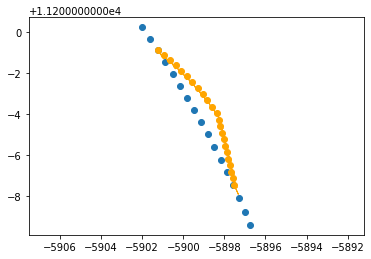

In [180]:
all_cam_transla = []
cam_idx = 1
for fr in scene.frames.values():
    cam_ed = fr.get_edge_by_child_idx([cam_idx])[0][0]
    all_cam_transla.append(cam_ed.translation.detach().numpy())
all_cam_transla = np.concatenate(all_cam_transla)[reference_id-2:reference_id+15]

ax = plt.figure()
plt.scatter(all_cam_transla[:, 0], all_cam_transla[:, 1])
plt.axis('equal')

# plt.scatter(cam_position[:,0], cam_position[:, 1], c="orange")

for t, r in zip(cam_position[:], cam_orientation[:]):
    plt.scatter(t[0], t[1], c="orange")
    plt.arrow(t[0], t[1], r[0, 2]*.5, r[1, 2]*.5, color="orange")
    plt.axis('equal')
    

plt.savefig(img_name + 'plt.png')
print(img_name)
# for fr in scene.frames.items:
#     fr.edges

In [178]:
# Export Render Pose Information
segmemt_pth = ''
for s in scene.dataset.images[0].split('/')[1:-2]:
    segmemt_pth += '/' + s

scene_descript = scene.frames_cameras[reference_id][2]
first_fr = scene_descript['first_frame']
last_fr = scene_descript['last_frame']
render_pose_file_n = "render_poses_{}_{}.npy".format(str(first_fr).zfill(4), str(last_fr).zfill(4))

# Get camera pose matrix for NeRF
cam_pose = np.concatenate([cam_orientation, cam_position[..., None]], axis=-1)
cam_pose = np.concatenate([cam_pose, np.repeat(np.array([[[0., 0., 0., 1.]]]), len(cam_pose), axis=0)], axis=1)
cam_pose_openGL = cam_pose.dot(np.array([[-1., 0., 0., 0., ], [0., 1., 0., 0., ], [0., 0., -1., 0., ], [0., 0., 0., 1., ], ]))

c_id = scene.frames_cameras[reference_id][1]
H = scene.nodes['camera'][c_id].H / exp_dict['scale']
W = scene.nodes['camera'][c_id].W / exp_dict['scale']
f = scene.nodes['camera'][c_id].intrinsics.f_x.detach().cpu().numpy() / exp_dict['scale']

hwf = np.repeat(np.array([[H, W, f, reference_id]]), len(cam_pose), axis=0)[..., None]
cam_pose_openGL = np.concatenate([cam_pose_openGL, hwf], axis=2)

cam_pose_openGL.shape

np.save(os.path.join(segmemt_pth, exp_name + '_' + render_pose_file_n,), cam_pose_openGL)
os.path.join(segmemt_pth, exp_name + '_' + render_pose_file_n)

'/home/julian.ost/workspace/renderer/NeuralSceneGraphs/data/waymo_open/validation/validation_validation_0000/segment-10247954040621004675_2180_000_2200_000_with_camera_labels/middle_curve_01_render_poses_0000_0080.npy'

### e) Epi Plane

In [163]:
bi = 11

time0 = time.time()
b = ut.collate_fn_dict_of_lists([scene.__getitem__(bi, intersections_only=False, random_rays=False,)])

(time.time()-time0)
b_neutral = copy.deepcopy(b)
dict_key = list(b['pts_dirs'][0].keys())[0]

7.0910797119140625


In [164]:
b = copy.deepcopy(b_neutral)

In [165]:
b['pts_dirs'][0][dict_key]

tensor([[ 0.9674,  0.0051,  0.2531],
        [ 0.9674,  0.0021,  0.2533],
        [ 0.9673, -0.0010,  0.2536],
        ...,
        [ 0.6364, -0.7071, -0.3082],
        [ 0.6342, -0.7092, -0.3079],
        [ 0.6320, -0.7114, -0.3075]])

In [176]:
n_steps = 41
min_angle = 0.
max_angle = 10.

x = [0, 239]
y = [120, 120]
patch_mask = np.meshgrid(
    np.linspace(y[0],y[1], y[1] - y[0] + 1, dtype=np.int), 
    np.linspace(x[0],x[1], x[1] - x[0] + 1, dtype=np.int),
    )
patch_mask = tuple(patch_mask)


diff = max_angle - min_angle

lf_epis = []
for i in range(n_steps):
    b = copy.deepcopy(b_neutral)
    angle = min_angle + max_angle * i
    s = torch.sin(torch.deg2rad(torch.tensor(angle)))
    c = torch.cos(torch.deg2rad(torch.tensor(angle)))
    rot_z = torch.tensor([[c, -s, 0],[s,c,0],[0,0,1],])
    b['pts_dirs'][0][dict_key] = torch.matmul(rot_z, b['pts_dirs'][0][dict_key].T).T
    
    with torch.no_grad():
        time1 = time.time()
        rgb_out = model.renderer.forward_on_batch(b)
        print(time.time()-time1)
    rendered_img = rgb_out['color_out'].reshape(b['images'][0].shape)
    lf_epis.append(rendered_img[patch_mask])

1.8353757858276367
2.004417657852173
1.648637056350708
1.7765114307403564
1.7476940155029297
1.6496493816375732
1.663440227508545
1.673259973526001
1.7178761959075928
1.6804735660552979
1.5878725051879883
1.5544688701629639
1.6338152885437012
1.5975077152252197
1.6037330627441406
1.6717658042907715
1.565669059753418
1.6909723281860352
1.5709056854248047
1.6533989906311035
1.6896965503692627
1.6419360637664795
1.5620553493499756
1.681119680404663
1.7563657760620117
1.6387906074523926
1.5964722633361816
1.6843478679656982
1.6002824306488037
1.6772525310516357
1.5326275825500488
1.6522340774536133
1.6840252876281738
1.5720691680908203
1.7406301498413086
1.6046397686004639
1.6796801090240479
2.0191824436187744
1.5376012325286865
1.579820156097412
1.652831792831421


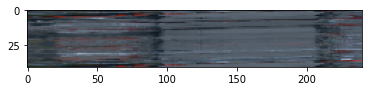

In [177]:
epi_img = np.flip(np.transpose(np.concatenate(lf_epis, axis=1), [1,0,2]), axis=0)
plt.imshow(epi_img)
hu.save_image('/data2/home/julian.ost/workspace/renderer/NeuralSceneGraphs/EPI.png', epi_img.copy())

In [162]:
with torch.no_grad():
    time1 = time.time()
    rgb_out = model.renderer.forward_on_batch(b)
    print(time.time()-time1)

rendered_img = rgb_out['color_out'].reshape(b['images'][0].shape)

1.8963284492492676


In [30]:
x = [0, 239]
y = [120, 120]
# x = [85, 93]
# y = [105, 105]
patch_mask = np.meshgrid(
    np.linspace(y[0],y[1], y[1] - y[0] + 1, dtype=np.int), 
    np.linspace(x[0],x[1], x[1] - x[0] + 1, dtype=np.int),
    )
patch_mask = tuple(patch_mask)

In [141]:
rendered_img[patch_mask]

(240, 1, 3)

(240, 1, 3)


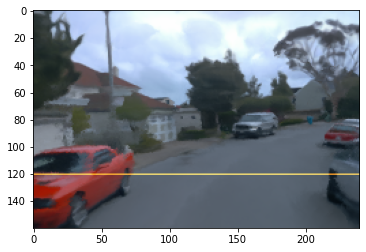

In [87]:
rendered_img_patched = copy.deepcopy(rendered_img)
rendered_img_patched[patch_mask] += np.array([1.0, 0.5, 0.])
print(rendered_img_patched[patch_mask].shape)
rendered_img_patched = np.clip(rendered_img_patched, 0.0, 1.0)
plt.imshow(rendered_img_patched)

# Run Point Cloud Light Field

In [ ]:
with torch.no_grad():
    time0 = time.time()
    rgb_out = model.renderer.forward_on_batch(b)
    print(time.time()-time0)

### Visualize output if batch from all image pixels

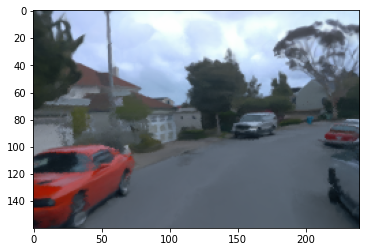

In [25]:
rendered_img = rgb_out['color_out'].reshape(b['images'][0].shape)
plt.imshow(rendered_img)

In [ ]:
rendered_img = rgb_out['color_out'].reshape(b['images'][0].shape)
plt.imshow(rendered_img)

In [ ]:
plt.imshow(b["images"][0].detach().cpu())

In [28]:
x = [0, 239]
y = [120, 120]
# x = [85, 93]
# y = [105, 105]
patch_mask = np.meshgrid(
    np.linspace(y[0],y[1], y[1] - y[0] + 1, dtype=np.int), 
    np.linspace(x[0],x[1], x[1] - x[0] + 1, dtype=np.int),
    )
patch_mask = tuple(patch_mask)

(240, 1, 3)


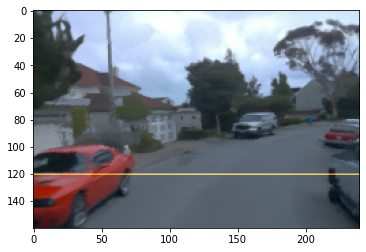

In [29]:
rendered_img_patched = copy.deepcopy(rendered_img)
rendered_img_patched[patch_mask] += np.array([1.0, 0.5, 0.])
print(rendered_img_patched[patch_mask].shape)
rendered_img_patched = np.clip(rendered_img_patched, 0.0, 1.0)
plt.imshow(rendered_img_patched)

In [ ]:
per_ray_features = rgb_out["per_ray_features"].reshape(list(b['images'][0].shape[:-1]) + [128])
per_ray_point_pair_features = rgb_out["sum_mv_point_features"].reshape(list(b['images'][0].shape[:-1]) + [lf_config["k_closest"], 128])
per_ray_point_attn = rgb_out["attention_weights"].squeeze().reshape(list(b['images'][0].shape[:-1]) + [lf_config["k_closest"]])
print("Ray Features of shape {} and Ray to k closest point features of shape{}.".format(per_ray_features.shape, per_ray_point_pair_features.shape))

In [ ]:
patch_features = per_ray_features[patch_mask].reshape(-1, 128)
patch_point_ray_features = per_ray_point_pair_features[patch_mask].reshape(-1,lf_config["k_closest"], 128 )
patch_point_ray_attn = per_ray_point_attn[patch_mask].reshape(-1,lf_config["k_closest"])

In [ ]:
patch_point_ray_features.mean(axis=-1)

In [ ]:
patch_point_ray_attn

In [ ]:
patch_features

### Visualize Features

In [ ]:
def get_feat_color(feat):
    assert len(feat.shape) == 2
    feat_embedded = TSNE(n_components=3).fit_transform(feat)
    feat_embedded = feat_embedded - feat_embedded.min(axis=0)
    color = feat_embedded / feat_embedded.max(axis=0)
    return color

In [ ]:
ray_feat = rgb_out["per_ray_features"].squeeze()


px_color = get_feat_color(ray_feat)

rb = rgb_out['ray_bundle']
xy = rb.xys[..., :2].squeeze().cpu().numpy()
img = scene.frames[0].load_image(1)
# img[xy[:, 1], xy[:, 0]] = px_color
plt.imshow(img)
plt.scatter(xy[:, 0], xy[:, 1], c=px_color)

In [ ]:
k = 0

pts = rgb_out['points_in'][k]
mask = rgb_out['closest_mask_in'][k]
feat_per_pts = rgb_out['sum_mv_point_features'].squeeze()
if len(feat_per_pts.shape) == 4:
    feat_per_pts = feat_per_pts[k]
    
n_rays, k_closest, feat_dim = feat_per_pts.shape
feat_per_pts = feat_per_pts.reshape(-1, feat_dim)

In [ ]:
pt_color = get_feat_color(feat_per_pts)

In [ ]:
pcd = get_pcd_vis(pts)
pcd.paint_uniform_color([1., 0.9, 0.])

pcd_closest = get_pcd_vis(pts[mask], color_vector=pt_color)

draw([pcd, pcd_closest])

In [ ]:
frame_id =
camera_id =

# Make sure rays are not randomly sampled
model.eval()
model.renderer.forward()
model.renderer._process_chunk()

# Might need to run the pipeline manually

# 1. Sample a set of adjacent rays

# 2. Run rest of the pipeline

# 3. Generate standard output


# 4. Ablation Outputs a) b) c) ...

In [ ]:
list(rgb_out.keys())

In [ ]:
# n_pix x k_closest
b['pts_idx'][0][(b['camera_id'][0], b['frame_id'][0])].shape
# 1 x n_pix x 3
b['ray_bundle'][0].origins.shape
# n_pix x 3
b['pts_dirs'][0][(b['camera_id'][0], b['frame_id'][0])].shape


pts_to_unpack = {
    0: 'pt_cloud_select',
    1: 'closest_point_dist',
    2: 'closest_point_azimuth',
    3: 'closest_point_pitch',

}
# pts[4] = 'output_dict'


# pts
# 0: 'pt_cloud_select', n_pts x 3
b['pts'][0][0][(b['camera_id'][0], b['frame_id'][0])].shape

# 1: 'closest_point_dist', n_pix x k_closest
b['pts'][0][1][(b['camera_id'][0], b['frame_id'][0])].shape

# 2: 'closest_point_azimuth', n_pix x k_closest
b['pts'][0][2][(b['camera_id'][0], b['frame_id'][0])].shape

# 3: 'closest_point_pitch', n_pix x k_closest
b['pts'][0][3][(b['camera_id'][0], b['frame_id'][0])].shape

# 4: 'output_dict', {}
b['pts'][0][4]

## Debug Point Cloud Merging

In [ ]:
kitti_pcd_dir = "/mnt/storage01-mun/dataset/users/jost/kitti_tracking/training/velodyne"
datadir = "0001/merged_pcd_kitti_scene_0001_frames_0000_0120_n_fr_0040"
merged_pcds = os.listdir(os.path.join(kitti_pcd_dir, datadir))


In [ ]:
pcd_path = os.path.join(kitti_pcd_dir, datadir, merged_pcds[0])
print(pcd_path)
pts = np.asarray(o3d.io.read_point_cloud(pcd_path).points)

pcd = get_pcd_vis(pts)
pcd.paint_uniform_color([1., 0.9, 0.])

draw([pcd])
# pts

In [ ]:
pcd = get_pcd_vis(rgb_out['points_in'])
draw([pcd])

In [ ]:
pcd

In [ ]:
def render_frame_from_cam_trafo(translation, euler_angles, scene, reference_id):
    ind_list = list(np.arange(len(scene)))
    
    # Copy reference frame
    ref_frame_idx = scene.frames_cameras[reference_id][0]
    ref_frame_copy = copy.deepcopy(scene.frames[ref_frame_idx])
    
    new_frame = scene.frames[ref_frame_idx]
    cam_idx = 1
    # print([(node_idx, cam_node.name) for (node_idx, cam_node) in scene.nodes['camera'].items()])
    assert scene.nodes['camera'][cam_idx].name == 'FRONT'
    camera_ed = new_frame.get_edge_by_child_idx([cam_idx])[0][0]
    cam_ed_idx = new_frame.get_edge_idx_by_child_idx([cam_idx])[0][0]
    # print(camera_ed.get_transformation_c2p().get_matrix().detach().cpu().numpy()[0].T)
    rot_skew_angle = copy.deepcopy(camera_ed.rotation)
    cam2wo_rot = so3_exponential_map(rot_skew_angle)
    cam2wo_translat = copy.deepcopy(camera_ed.translation)
    # print(cam2wo_rot)


    # Create new camera edge
    DTYPE = camera_ed.translation.dtype
    DEVICE = camera_ed.translation.device

    # Get changed rotation
    euler_angels_torch = torch.tensor(euler_angles, dtype=DTYPE, device=DEVICE)
    rot_change = euler_angles_to_matrix(euler_angels_torch, 'ZYX')
    new_rot = torch.matmul(cam2wo_rot, rot_change)
    assert torch.norm(torch.matmul(new_rot[0], new_rot[0].T) - torch.eye(3)) < 1e-5

    # Get changed camera
    translation_change_camera = torch.tensor(translation_change, dtype=DTYPE, device=DEVICE)
    translation_change_world = torch.matmul(new_rot[0], translation_change_camera)

    camera_ed.translation = cam2wo_translat + translation_change_world
    print("Reference Translation: {}; New Translation {}".format(
        cam2wo_translat.detach().cpu().numpy(),
        scene.frames[ref_frame_idx].edges[cam_ed_idx].translation.detach().cpu().numpy()))
    camera_ed.rotation = so3_log_map(new_rot)
    print("Reference Rotation: {}; New Rotation {}".format(
        rot_skew_angle.detach().cpu().numpy(),
        scene.frames[ref_frame_idx].edges[cam_ed_idx].rotation.detach().cpu().numpy()))
    

    # Preprocess new frame
    print("Extracting rays and points of the new frame")
    bi = ind_list[reference_id]
    batch = ut.collate_fn_dict_of_lists([scene.__getitem__(bi, intersections_only=False, random_rays=False,)])
    print("Done.")
    print("Rendering New Frame")
    rgb_out = model.renderer.forward_on_batch(batch)
    print("Done.")
    
    # Reverse Scene Graph Manipulation
    scene.frames[ref_frame_idx] = copy.deepcopy(ref_frame_copy)
    
    ref_shape = batch['images'][0].shape
    
    return rgb_out, ref_shape
    